# Graphs and Dataframes

## Datasets

In [1]:
import numpy as np
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import math
warnings.filterwarnings('ignore')

def find_neighbors(G, node):
    successors = set(G.successors(node))
    predecessors = set(G.predecessors(node))
    neighbors = successors | predecessors
    return len(neighbors)

def read_net_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    nodes = {}
    n_states = 0
    create = True
    
    for line in lines:
        if line.strip() and not line.startswith('*'):  # Ignora le righe vuote e i commenti
            parts = line.strip().split()
            if len(parts) == 5:
                nodes[int(parts[0])-1] = [parts[1].replace('"', ''), float(parts[2]), float(parts[3])]
                n_states += 1
            elif len(parts) == 3:
                if create:
                    matrix = [[0 for _ in range(n_states)] for _ in range(n_states)]
                    create = False
                matrix[int(parts[0])-1][int(parts[1])-1] = float(parts[2])

    return nodes, matrix

In [2]:
dataset_folder = Path.cwd().joinpath("datasets")
data2000 = dataset_folder.joinpath("2000.net")

nodes, m2000 = read_net_file(data2000)

In [3]:
G2000 = nx.DiGraph()

for r in range(len(m2000)):
  for c in range(len(m2000[r])):
    if m2000[r][c]>0:
      G2000.add_edge(nodes[r][0], nodes[c][0], price=m2000[r][c])

print(G2000)

DiGraph with 161 nodes and 16335 edges


## Binary graph

In [4]:
Tot2000 = {'Imp':[sum(i) for i in m2000], 'Exp':[sum([m2000[j][i] for j in range(len(m2000))]) for i in range(len(m2000))], 'ImpPartners':[sum(1 for e in i if e > 0) for i in m2000], 'ExpPartners':[sum([1 for j in range(len(m2000)) if m2000[j][i] > 0]) for i in range(len(m2000))]}

threshold = 0.1

G2000bin = nx.DiGraph()


for r in range(len(m2000)):
  for c in range(len(m2000[r])):
    if (m2000[r][c]>0) and ((m2000[r][c]>threshold*Tot2000['Imp'][r])) and ((m2000[r][c]>threshold*Tot2000['Exp'][c])):
      G2000bin.add_edge(nodes[r][0], nodes[c][0], importance='both', price=m2000[r][c])
    elif (m2000[r][c]>0) and ((m2000[r][c]>threshold*Tot2000['Imp'][r])):
      G2000bin.add_edge(nodes[r][0], nodes[c][0], importance='import', price=m2000[r][c])
    elif (m2000[r][c]>0) and ((m2000[r][c]>threshold*Tot2000['Exp'][c])):
      G2000bin.add_edge(nodes[r][0], nodes[c][0], importance='export', price=m2000[r][c])

print(G2000bin)

DiGraph with 161 nodes and 622 edges


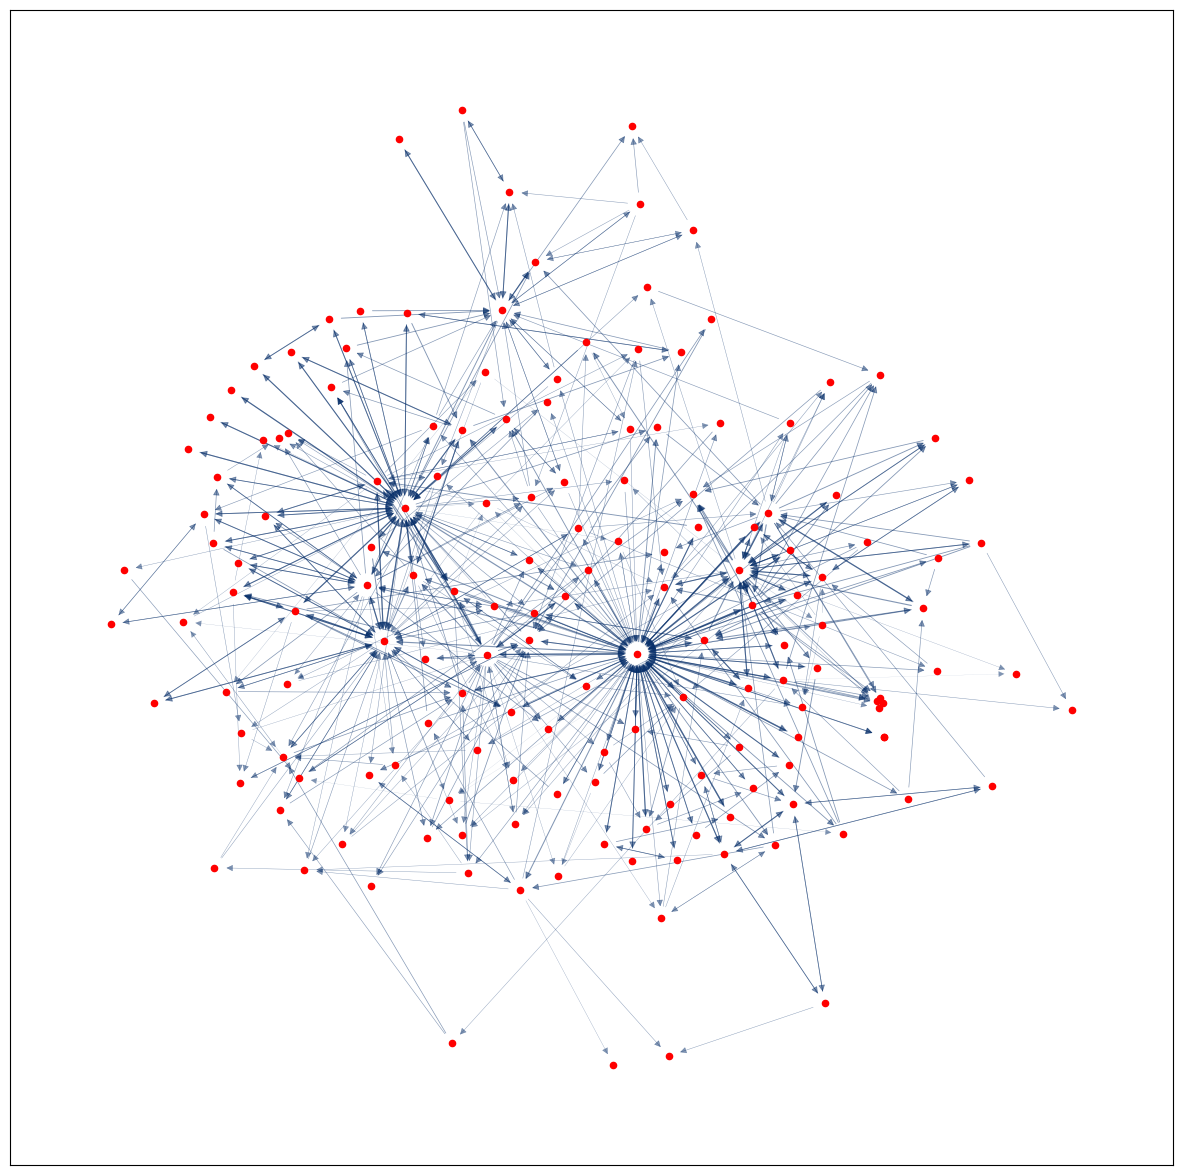

In [5]:
prices = nx.get_edge_attributes(G2000bin, 'price').values()
prices = [math.log(i) for i in list(prices)]
max_price = max(prices)
min_price = min(prices)
norm_prices = [(price - min_price) / (max_price - min_price) for price in prices]

edges = G2000bin.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]

# draw the graph
pos = nx.kamada_kawai_layout(G2000bin)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G2000bin, pos, node_size=20, node_color='red', label=True)
#nx.draw_networkx_edges(G2000lite, pos, alpha=0.5)
nx.draw_networkx_edges(G2000bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)

plt.savefig("network2000.png")
plt.show()

In [6]:
G2000.edges.data('price')

OutEdgeDataView([('ALB', 'ARE', 1197.07), ('ALB', 'ARG', 162.552), ('ALB', 'ARM', 147.911), ('ALB', 'AUS', 776.949), ('ALB', 'AUT', 11840.4), ('ALB', 'AZE', 7.847), ('ALB', 'BEL', 2936.27), ('ALB', 'BGR', 25911.9), ('ALB', 'BIH', 91.588), ('ALB', 'BLR', 6895.03), ('ALB', 'BOL', 16.033), ('ALB', 'BRA', 1187.76), ('ALB', 'CAF', 0.629), ('ALB', 'CAN', 1463.84), ('ALB', 'CHE', 13422.0), ('ALB', 'CHN', 14696.6), ('ALB', 'CIV', 19.97), ('ALB', 'COL', 1030.44), ('ALB', 'CRI', 46.608), ('ALB', 'CYP', 3181.61), ('ALB', 'CZE', 5927.99), ('ALB', 'DEU', 66369.8), ('ALB', 'DNK', 3831.2), ('ALB', 'ECU', 3130.79), ('ALB', 'EGY', 2126.33), ('ALB', 'ESP', 12677.2), ('ALB', 'EST', 22.94), ('ALB', 'FIN', 5833.02), ('ALB', 'FRA', 14976.9), ('ALB', 'GBR', 8785.13), ('ALB', 'GEO', 183.13), ('ALB', 'GRC', 288023.0), ('ALB', 'HKG', 664.399), ('ALB', 'HRV', 12883.9), ('ALB', 'HTI', 1.097), ('ALB', 'HUN', 10999.9), ('ALB', 'IDN', 44.978), ('ALB', 'IND', 2739.9), ('ALB', 'IRL', 1707.03), ('ALB', 'IRN', 359.091),

## Df creation

In [7]:
gdp_df = pd.read_csv('datasets/GDP.csv')
gdp2000 = gdp_df[gdp_df['Year']==2000][['Code', 'GDP (constant 2015 US$)']]

node_in =  pd.DataFrame.from_dict(dict(G2000.in_degree()),orient="index", columns=['Imp Deg']).reset_index()
node_out =  pd.DataFrame.from_dict(dict(G2000.out_degree()),orient="index", columns=['Exp Deg']).reset_index()
df_2000 = pd.merge(node_in, node_out, on='index')
df_2000 = df_2000.sort_values(by='index')
df_2000.reset_index(drop=True, inplace=True)
df_2000['Tot Deg'] = df_2000['Imp Deg'] + df_2000['Exp Deg']
df_2000['Import'] = Tot2000['Imp']
df_2000['Export'] = Tot2000['Exp']
df_2000['Tot Partners'] = [find_neighbors(G2000, i) for i in df_2000['index']]
df_2000['GDP'] = [np.NaN for _ in range(len(df_2000))]
for id in df_2000['index']:
    try:
        df_2000.loc[df_2000['index'] == id, 'GDP'] = gdp2000.loc[gdp2000['Code'] == id, 'GDP (constant 2015 US$)'].iloc[0]
    except:
        continue


df_2000

index  Imp Deg  Exp Deg  Tot Deg        Import        Export  \
0     AGO       67        0       67  0.000000e+00  7.679389e+06   
1     ALB       85       78      163  1.069578e+06  2.898676e+05   
2     ARE      131        0      131  0.000000e+00  3.673976e+07   
3     ARG      130      133      263  2.442005e+07  2.585098e+07   
4     ARM       77       71      148  8.186318e+05  2.608760e+05   
..    ...      ...      ...      ...           ...           ...   
156   VNM      127      123      250  1.367300e+07  1.354223e+07   
157   YEM       80       87      167  2.181239e+06  3.437099e+06   
158   ZAF      138      157      295  2.587589e+07  3.154662e+07   
159   ZMB       89      111      200  8.673829e+05  5.933704e+05   
160   ZWE      110        0      110  0.000000e+00  1.820346e+06   

     Tot Partners           GDP  
0              67  3.130450e+10  
1             105  6.057219e+09  
2             131  2.004103e+11  
3             147  3.956461e+11  
4              93  3.959425e+09  
..            ...           ...  
156           144  9.352583e+10  
157           104  4.149824e+10  
158           157  2.216920e+11  
159           122  8.059030e+09  
160           110  1.984102e+10  

[161 rows x 8 columns]

In [8]:
param = 'Import' # Choose between the df columns

percentile_99 = np.percentile(df_2000[param], 98)
hub_nodi = df_2000[df_2000[param] >= percentile_99]['index'].tolist()
print('Nodes hub 2000: ', hub_nodi)

Nodes hub 2000:  ['DEU', 'GBR', 'JPN', 'USA']


# Analysis on the binary graph

## Density

In [9]:
density = round(nx.density(G2000bin),3)
densityTot = round(nx.density(G2000),3)
print('2000 | Total density: {} | over 10%: {}'.format(densityTot, density))

2000 | Total density: 0.634 | over 10%: 0.024


## Degree

Standard deviation: 13.92704486257657
Mean: 7.726708074534161
Median: 5.0
Min: 1
Max: 142
Assortativity coefficient: -0.3303142533781133


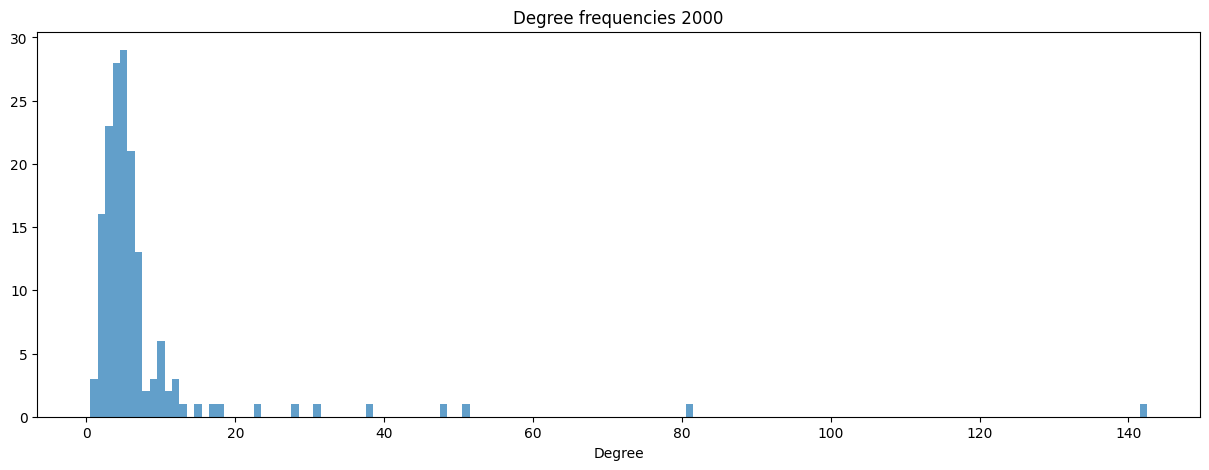

In [10]:
degree = list(dict(G2000bin.degree()).values())
print('Standard deviation: {}'.format(np.std(degree)))
print('Mean: {}'.format(np.mean(degree)))
print('Median: {}'.format(np.median(degree)))
print('Min: {}'.format(np.min(degree)))
print('Max: {}'.format(np.max(degree)))
print("Assortativity coefficient: " + str(nx.degree_assortativity_coefficient(G2000bin)))

plt.figure(figsize=(15,5))
plt.hist(degree, bins=np.arange(min(degree), max(degree) + 2) - 0.5, alpha=0.7)
plt.xlabel('Degree')
plt.title('Degree frequencies 2000')
plt.savefig('DegreeFreq2000')
plt.show()


In [11]:
print(dict(G2000bin.degree()))

{'ALB': 4, 'GRC': 8, 'ITA': 31, 'ARG': 10, 'BRA': 11, 'PRY': 5, 'URY': 5, 'USA': 142, 'ARM': 6, 'BEL': 18, 'RUS': 28, 'ATG': 3, 'AUS': 11, 'FJI': 4, 'JPN': 48, 'NZL': 7, 'PNG': 5, 'AUT': 2, 'DEU': 81, 'AZE': 7, 'TUR': 8, 'BDI': 7, 'FRA': 51, 'SAU': 12, 'TZA': 5, 'CAF': 4, 'GIN': 5, 'GMB': 5, 'LBR': 3, 'LSO': 3, 'LUX': 7, 'NLD': 12, 'BEN': 5, 'BFA': 5, 'CIV': 10, 'BGD': 4, 'CHN': 23, 'BGR': 5, 'BHR': 3, 'BHS': 4, 'BLR': 2, 'BOL': 6, 'BRB': 3, 'TTO': 9, 'BWA': 2, 'ZAF': 15, 'CMR': 5, 'CAN': 2, 'CHE': 5, 'LBN': 3, 'CHL': 4, 'AGO': 2, 'COG': 3, 'GNQ': 3, 'HKG': 7, 'KAZ': 7, 'KGZ': 6, 'KOR': 17, 'MNG': 5, 'OMN': 5, 'YEM': 6, 'ZMB': 4, 'NGA': 10, 'COL': 4, 'COM': 6, 'KEN': 6, 'PAK': 5, 'CRI': 4, 'CYP': 4, 'GBR': 38, 'CZE': 4, 'SVK': 5, 'BIH': 3, 'DNK': 4, 'ESP': 13, 'ETH': 3, 'FIN': 5, 'GRD': 4, 'HRV': 6, 'HUN': 2, 'IRL': 5, 'ISL': 5, 'LTU': 3, 'LVA': 6, 'MKD': 7, 'MLT': 7, 'NOR': 10, 'NPL': 4, 'POL': 2, 'PRT': 9, 'SVN': 6, 'SWE': 10, 'TCD': 2, 'TUN': 6, 'UGA': 2, 'DMA': 4, 'DZA': 5, 'ECU': 

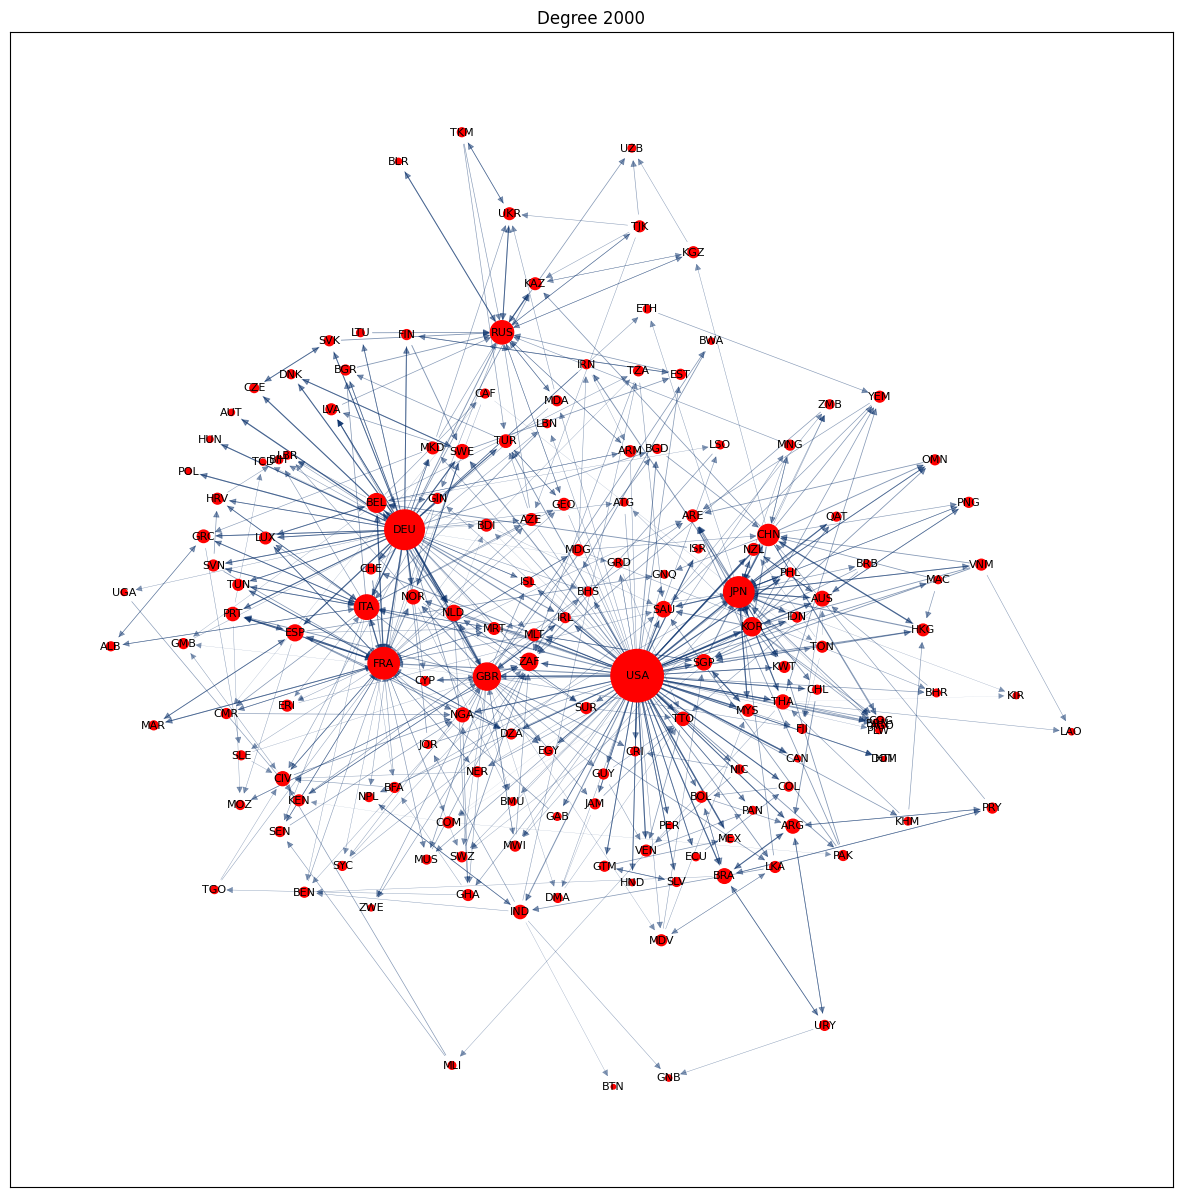

In [12]:
edges = G2000bin.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]
node_size = [v*10 for v in degree]

# draw the graph
pos = nx.kamada_kawai_layout(G2000bin)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G2000bin, pos, node_size=node_size, node_color='red', label=True)
nx.draw_networkx_edges(G2000bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)
nx.draw_networkx_labels(G2000bin, pos, font_size = 8)

plt.title('Degree 2000')

plt.savefig("Degree2000.png")
plt.show()

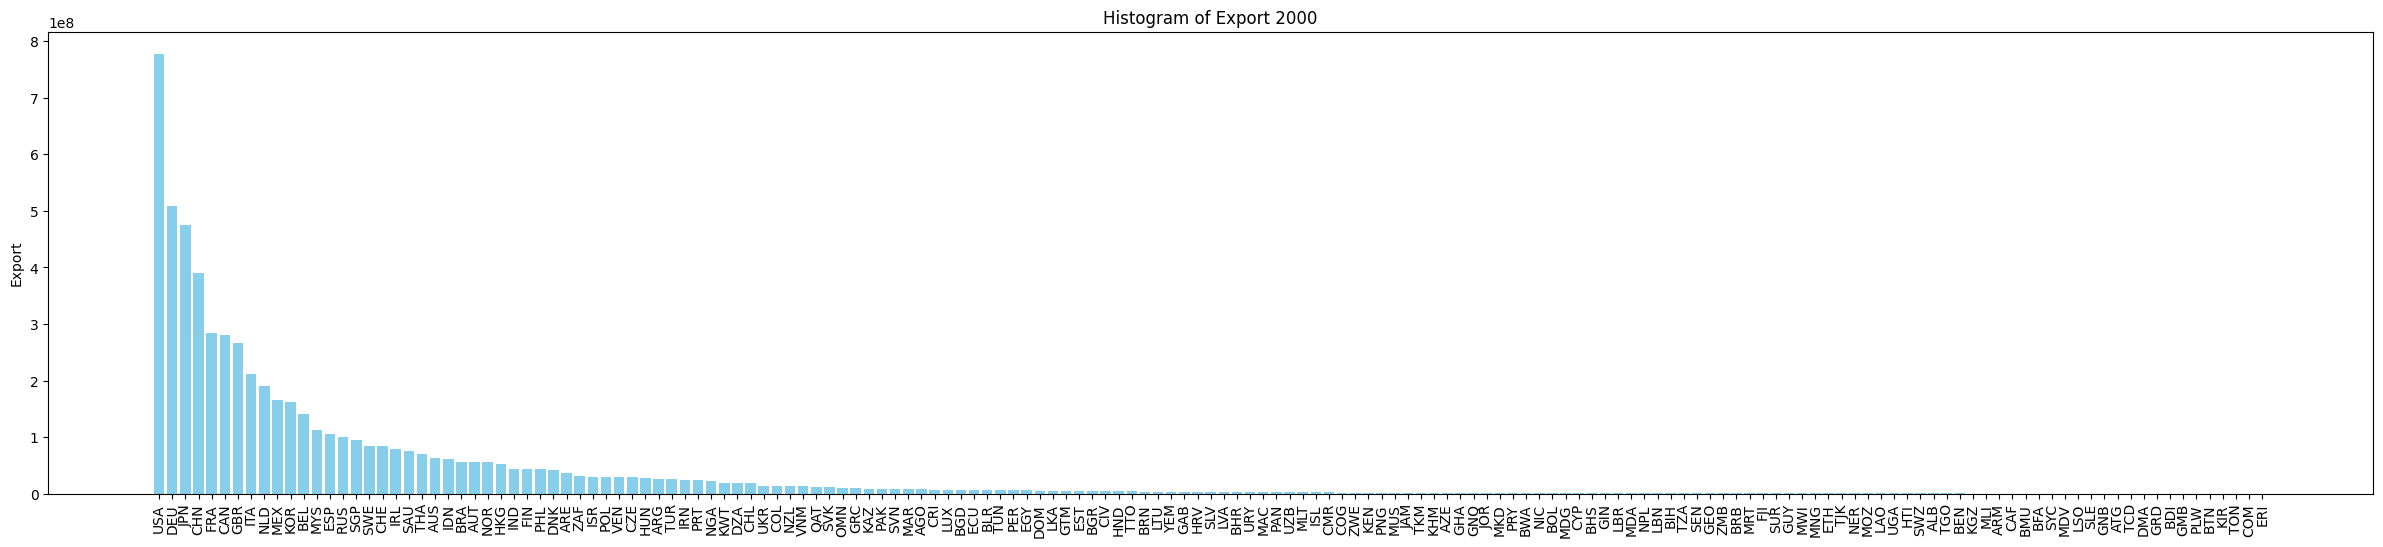

In [13]:
plot = 'Export'
plt.figure(figsize=(30, 6))
plt.bar(df_2000.sort_values(by=plot, ascending=False)['index'], df_2000.sort_values(by=plot, ascending=False)[plot], color='skyblue')
plt.ylabel(plot)
plt.title('Histogram of '+plot+' 2000')
plt.xticks(rotation=90)
plt.savefig(plot+"2000.png")
plt.show()


In [14]:
print(list(nx.isolates(G2000)))

[]


## Clustering

In [15]:
clusters = nx.average_clustering(G2000bin, weight='wheight') #weight='price'
clusters

0.44040537144601866

In [16]:
local_cluster = nx.clustering(G2000bin, weight='weight')
sorted(local_cluster.items(), key=lambda item: item[1], reverse= True)


[('ALB', 1.0),
 ('AGO', 1.0),
 ('CZE', 1.0),
 ('BIH', 1.0),
 ('DNK', 1.0),
 ('TCD', 1.0),
 ('TUN', 1.0),
 ('ECU', 1.0),
 ('MAR', 1.0),
 ('MEX', 1.0),
 ('SLV', 1.0),
 ('KIR', 1.0),
 ('PHL', 1.0),
 ('PLW', 1.0),
 ('QAT', 1.0),
 ('PAN', 1.0),
 ('SVN', 0.9230769230769231),
 ('CYP', 0.9),
 ('NZL', 0.8888888888888888),
 ('LUX', 0.8888888888888888),
 ('IRL', 0.875),
 ('IDN', 0.875),
 ('COG', 0.8333333333333334),
 ('BRN', 0.8333333333333334),
 ('MAC', 0.8333333333333334),
 ('BHS', 0.8),
 ('CHL', 0.8),
 ('COL', 0.8),
 ('CRI', 0.8),
 ('NIC', 0.8),
 ('BOL', 0.7692307692307693),
 ('HRV', 0.7692307692307693),
 ('PNG', 0.75),
 ('ISL', 0.75),
 ('GTM', 0.75),
 ('TON', 0.75),
 ('GUY', 0.7222222222222222),
 ('KWT', 0.6923076923076923),
 ('LBR', 0.6666666666666666),
 ('BRB', 0.6666666666666666),
 ('OMN', 0.6666666666666666),
 ('DMA', 0.6666666666666666),
 ('JAM', 0.6666666666666666),
 ('MYS', 0.6666666666666666),
 ('UZB', 0.6666666666666666),
 ('SVK', 0.625),
 ('VEN', 0.6071428571428571),
 ('GRD', 0.6),


## Centrality

In [17]:
import statistics
deg_centr = nx.degree_centrality(G2000bin)
sort_orders = sorted(deg_centr.items(), key=lambda x: x[1], reverse=True)
avg_degree_centrality = sum(deg_centr.values()) / len(deg_centr)
print('average of degree centrality: {}'.format(avg_degree_centrality))

degree_centrality_values = list(deg_centr.values())
median_degree_centrality = statistics.median(degree_centrality_values)
print('median of degree centrality: {}'.format(median_degree_centrality))
print('min of degree centrality: {}'.format(sort_orders[-1]))
print('max of degree centrality: {}'.format(sort_orders[0]))

print("10 most important nodes for Degree Centrality:")
for i in range(10):
  print(sort_orders[i])

average of degree centrality: 0.04829192546583852
median of degree centrality: 0.03125
min of degree centrality: ('HTI', 0.00625)
max of degree centrality: ('USA', 0.8875000000000001)
10 most important nodes for Degree Centrality:
('USA', 0.8875000000000001)
('DEU', 0.50625)
('FRA', 0.31875000000000003)
('JPN', 0.30000000000000004)
('GBR', 0.23750000000000002)
('ITA', 0.19375)
('RUS', 0.17500000000000002)
('CHN', 0.14375000000000002)
('BEL', 0.1125)
('KOR', 0.10625000000000001)


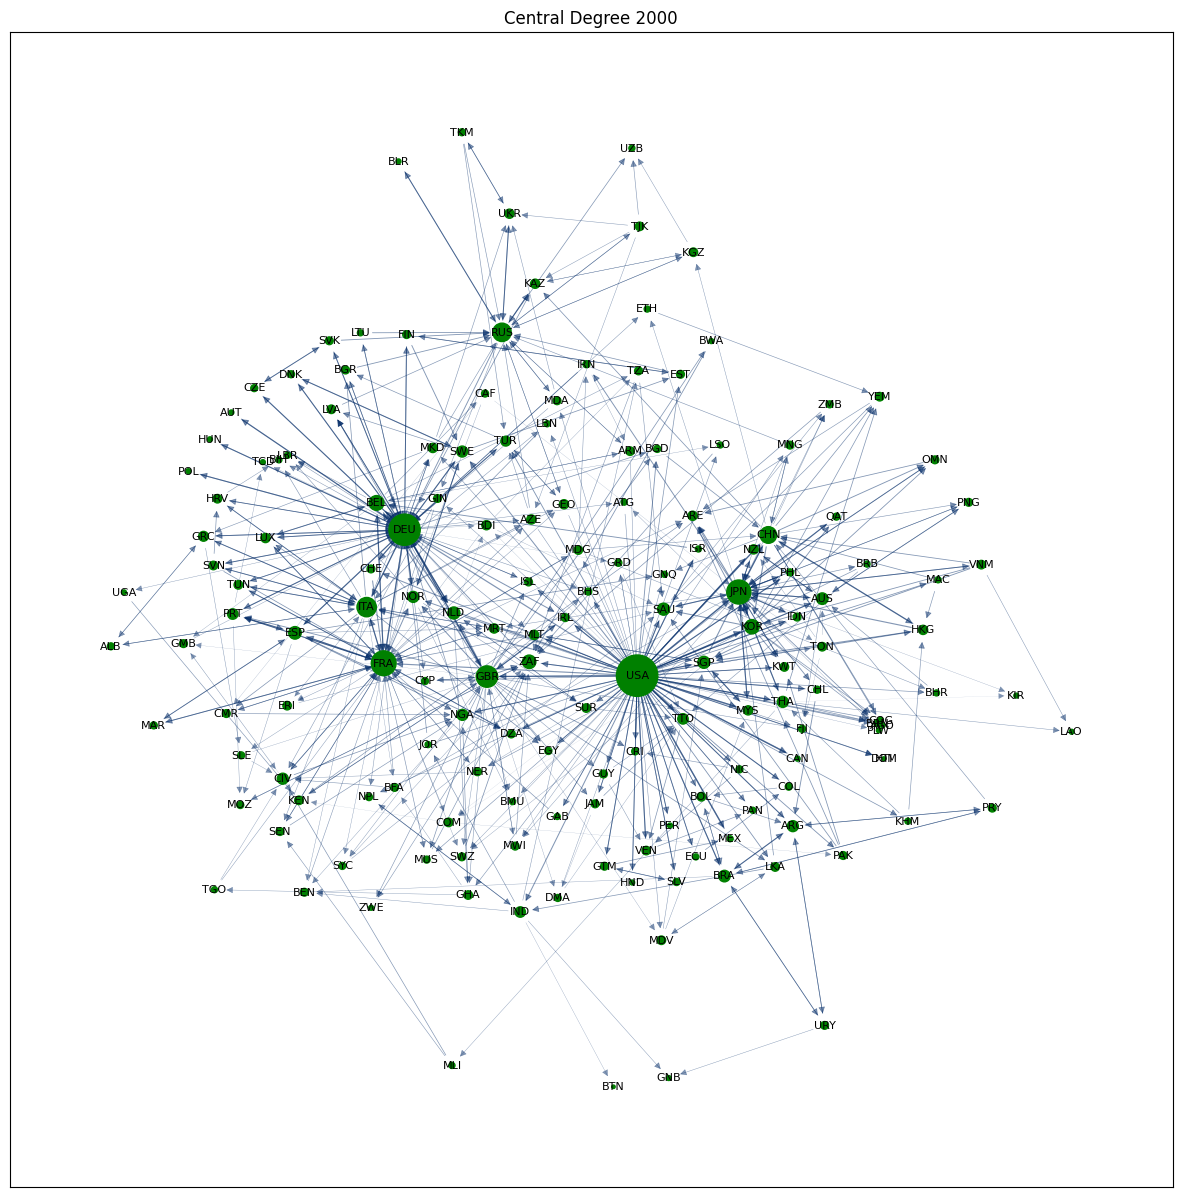

In [18]:
edges = G2000bin.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]
node_size = [deg_centr[i]*1000 for i in deg_centr]

# draw the graph
pos = nx.kamada_kawai_layout(G2000bin)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G2000bin, pos, node_size=node_size, node_color='green', label=True)
nx.draw_networkx_edges(G2000bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)
nx.draw_networkx_labels(G2000bin, pos, font_size = 8)

plt.title('Central Degree 2000')

plt.savefig("CentralDegree2000.png")
plt.show()

## Betweeness

In [19]:
betweenesCentrality = nx.betweenness_centrality(G2000bin, weight='weight')
sort_orders = sorted(betweenesCentrality.items(), key=lambda x: x[1], reverse=True)

avg_degree_betweenesCentrality = sum(betweenesCentrality.values()) / len(betweenesCentrality)
print('average of bewteenness centrality: {}'.format(avg_degree_betweenesCentrality))
print("10 most important nodes for Betweennes Centrality:")
print('max of betweenes centrality: {}'.format(sort_orders[0]))
for i in range(10):
  print(sort_orders[i])

average of bewteenness centrality: 0.010231356693620845
10 most important nodes for Betweennes Centrality:
max of betweenes centrality: ('USA', 0.5407232740622819)
('USA', 0.5407232740622819)
('DEU', 0.24467239817684922)
('FRA', 0.09782332883194042)
('JPN', 0.07085667972050233)
('GBR', 0.06545941460587829)
('RUS', 0.05975608244268478)
('ZAF', 0.05156599816718092)
('ITA', 0.04784008388600434)
('CHN', 0.036527262712720325)
('SAU', 0.02998187441476964)


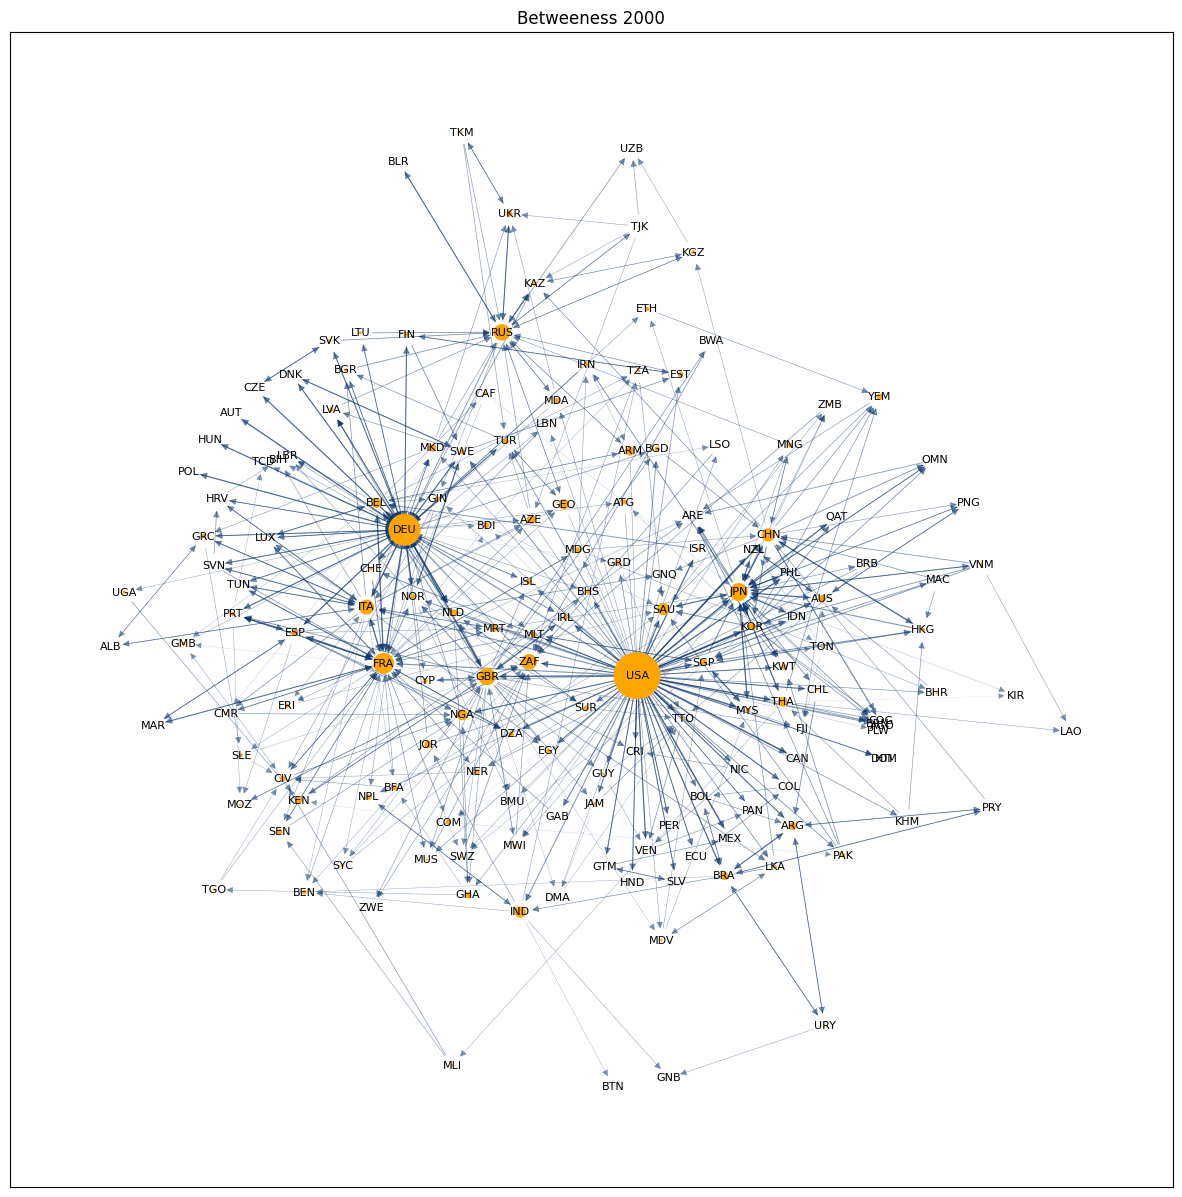

In [20]:
edges = G2000bin.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]
node_size = [betweenesCentrality[i]*2000 for i in betweenesCentrality]

# draw the graph
pos = nx.kamada_kawai_layout(G2000bin)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G2000bin, pos, node_size=node_size, node_color='orange', label=True)
nx.draw_networkx_edges(G2000bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)
nx.draw_networkx_labels(G2000bin, pos, font_size = 8)
plt.title('Betweeness 2000')

plt.savefig("betweeness2000.png")
plt.show()

## Eigenvector

In [21]:
eigen = nx.eigenvector_centrality(G2000bin, weight='weight')
sort_orders = sorted(eigen.items(), key=lambda x: x[1], reverse=True)

avg_degree_eignCentrality = sum(eigen.values()) / len(eigen)
print('average of eignvector centrality: {}'.format(avg_degree_eignCentrality))
print('max of eigenvector centrality: {}'.format(sort_orders[0]))
print("10 most important nodes for Eigenvector Centrality:")
for i in range(10):
  print(sort_orders[i])

average of eignvector centrality: 0.06227328232955395
max of eigenvector centrality: ('USA', 0.4063811279924369)
10 most important nodes for Eigenvector Centrality:
('USA', 0.4063811279924369)
('DEU', 0.3449947107002356)
('FRA', 0.25963751775690147)
('JPN', 0.17783682310638546)
('ITA', 0.16263694242286214)
('NOR', 0.13410534205592128)
('GBR', 0.12023242145546999)
('ZAF', 0.10734670722718809)
('SWE', 0.10603468771275006)
('BEL', 0.1058059094755323)


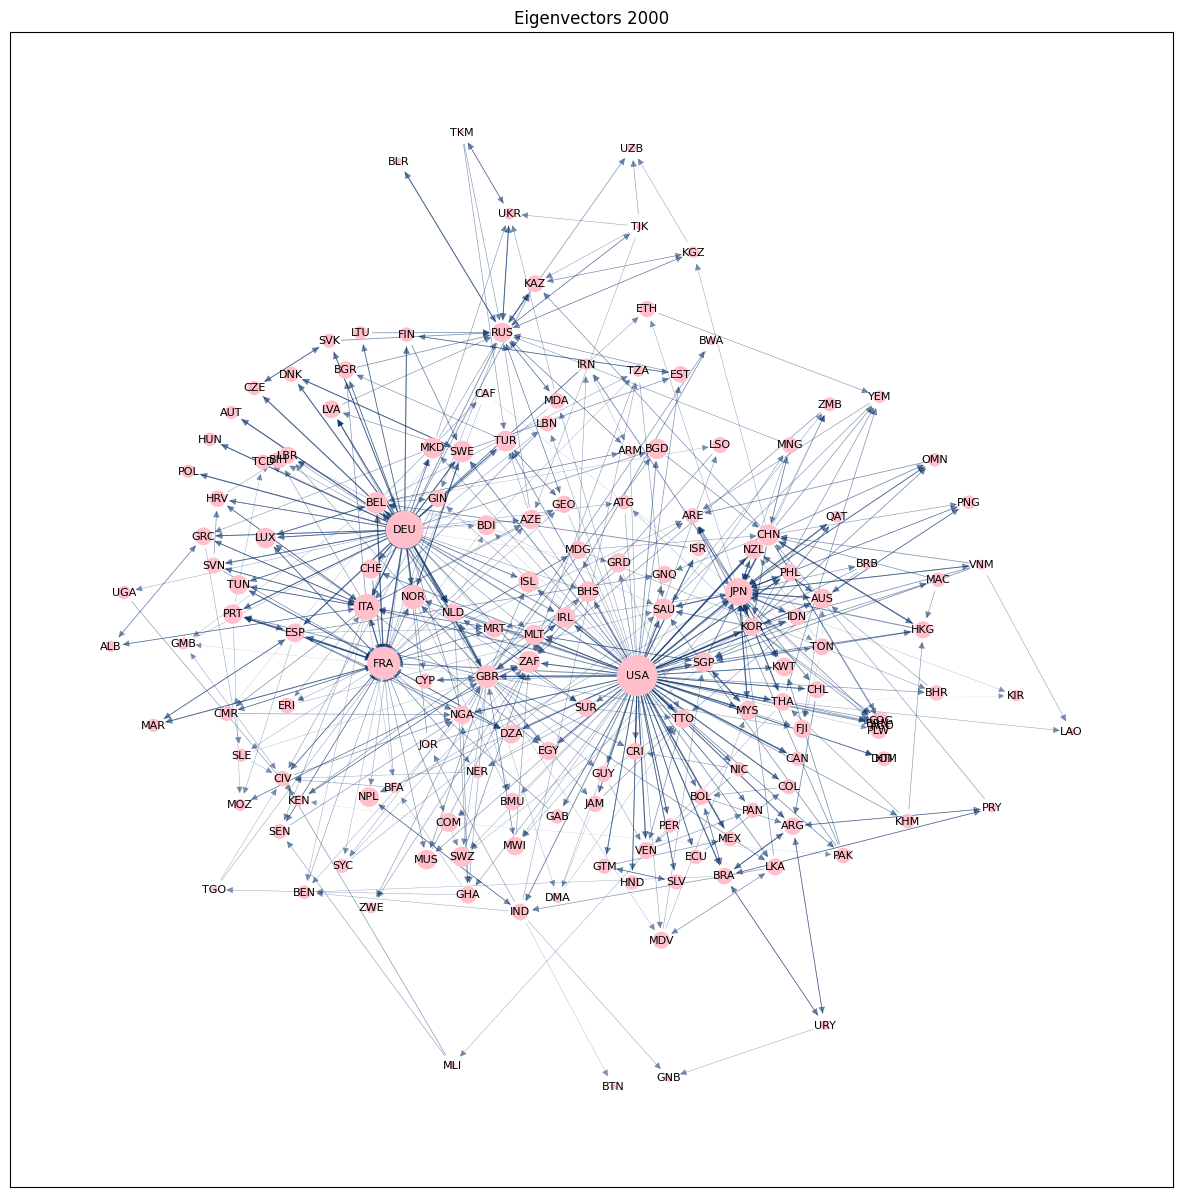

In [22]:
edges = G2000bin.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]
node_size = [eigen[i]*2000 for i in eigen]

# draw the graph
pos = nx.kamada_kawai_layout(G2000bin)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G2000bin, pos, node_size=node_size, node_color='pink', label=True)
nx.draw_networkx_edges(G2000bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)
nx.draw_networkx_labels(G2000bin, pos, font_size = 8)
plt.title('Eigenvectors 2000')

plt.savefig("Eigenvector2000.png")
plt.show()

## Pagerank

In [23]:
pagerank = nx.pagerank(G2000bin, alpha=0.85, weight='weight')
sort_orders = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)


avg_degree_pagerank = sum(pagerank.values()) / len(pagerank)
print('average of pagerank : {}'.format(avg_degree_pagerank))
print('max of pagerank: {}'.format(sort_orders[0]))
print("10 most important nodes for Page Rank:")
for i in range(10):
  print(sort_orders[i])

average of pagerank : 0.006211180124223604
max of pagerank: ('USA', 0.09618886072754339)
10 most important nodes for Page Rank:
('USA', 0.09618886072754339)
('DEU', 0.05699840720371711)
('FRA', 0.04020576722120342)
('RUS', 0.03353381931393493)
('ZAF', 0.031928179666287755)
('JPN', 0.027243966019390962)
('ITA', 0.015213504942635656)
('GBR', 0.013508870116852255)
('NGA', 0.012339363033744636)
('CHN', 0.012037302270120266)


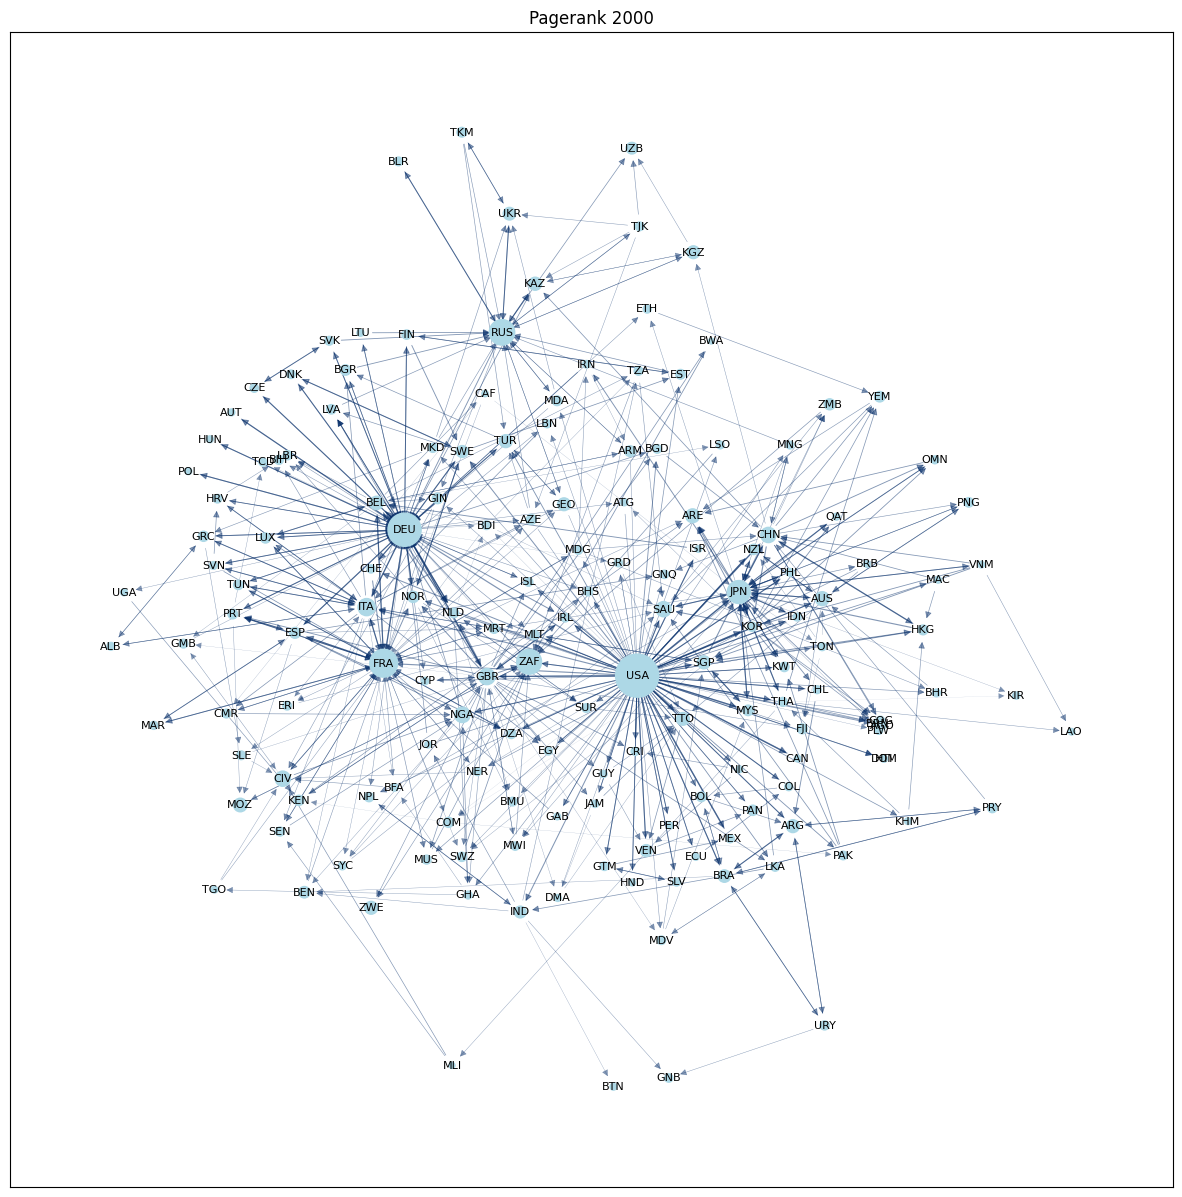

In [24]:
edges = G2000bin.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]
node_size = [pagerank[i]*10000 for i in pagerank]

# draw the graph
pos = nx.kamada_kawai_layout(G2000bin)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G2000bin, pos, node_size=node_size, node_color='lightblue', label=True)
nx.draw_networkx_edges(G2000bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)
nx.draw_networkx_labels(G2000bin, pos, font_size = 8)
plt.title('Pagerank 2000')

plt.savefig("Pagerank2000.png")
plt.show()

## Closeness

In [25]:
closeness = nx.closeness_centrality(G2000bin)
sort_orders = sorted(closeness.items(), key=lambda x: x[1], reverse=True)

avg_degree_closeness = sum(closeness.values()) / len(closeness)
print('average of closeness : {}'.format(avg_degree_closeness))

print("10 most important nodes for closeness_centrality:")
for i in range(10):
  print(sort_orders[i])

average of closeness : 0.3155007328327815
10 most important nodes for closeness_centrality:
('USA', 0.4724572243346008)
('DEU', 0.4706676136363636)
('FRA', 0.425535102739726)
('ITA', 0.3969848242811502)
('NOR', 0.3907429245283019)
('GBR', 0.3870911214953271)
('TUR', 0.37426581325301206)
('BGD', 0.37426581325301206)
('BHS', 0.3731418918918919)
('IRL', 0.3731418918918919)


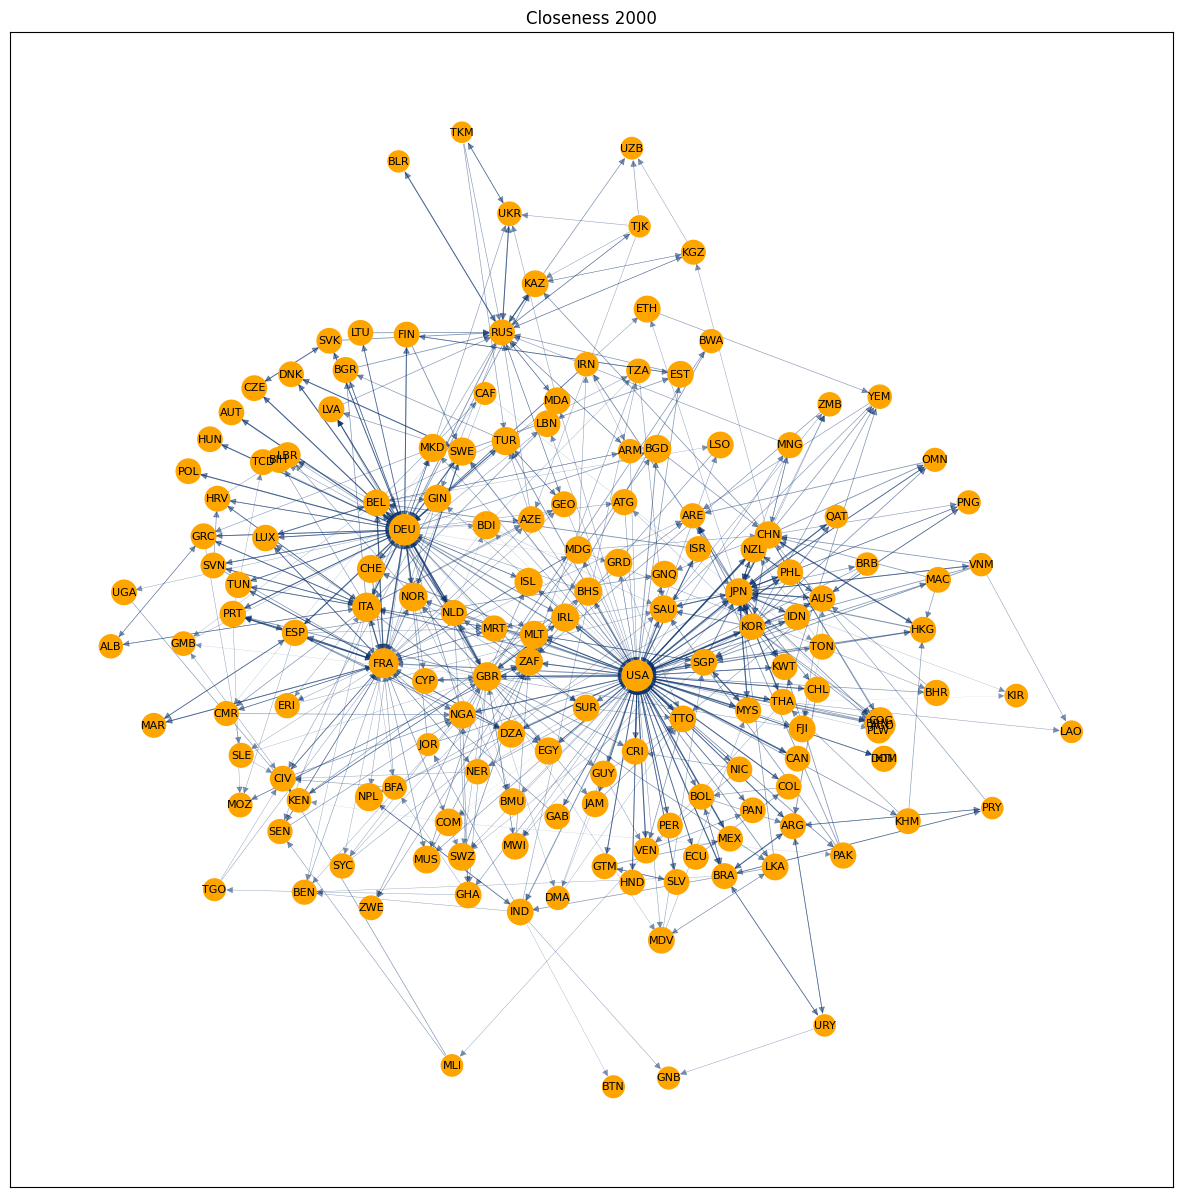

In [26]:
edges = G2000bin.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]
node_size = [closeness[i]*1000 for i in closeness]

# draw the graph
pos = nx.kamada_kawai_layout(G2000bin)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G2000bin, pos, node_size=node_size, node_color='orange', label=True)
nx.draw_networkx_edges(G2000bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)
nx.draw_networkx_labels(G2000bin, pos, font_size = 8)
plt.title('Closeness 2000')

plt.savefig("closeness2000.png")
plt.show()

## Communities

In [27]:
import networkx.algorithms.community as nx_comm
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

list_community_sets_greedy = list(nx_comm.greedy_modularity_communities(G2000bin,weight='weight'))
print(list_community_sets_greedy[0:20])

[frozenset({'AUS', 'MAC', 'QAT', 'ZMB', 'HKG', 'MYS', 'ATG', 'KIR', 'BRN', 'PLW', 'VNM', 'THA', 'PHL', 'KOR', 'KHM', 'SAU', 'ETH', 'NZL', 'CHN', 'YEM', 'IDN', 'FJI', 'ARE', 'AGO', 'MNG', 'KWT', 'PNG', 'TON', 'MLT', 'COG', 'PAK', 'JPN', 'OMN', 'SGP', 'LAO'}), frozenset({'URY', 'SLV', 'HTI', 'BRB', 'PRY', 'COL', 'PER', 'MEX', 'ISR', 'CHL', 'GUY', 'EGY', 'ARG', 'NIC', 'GTM', 'HND', 'DOM', 'VEN', 'TTO', 'CAN', 'GAB', 'BHS', 'PAN', 'BRA', 'USA', 'ECU', 'GRD', 'BOL', 'JAM', 'DMA', 'CRI'}), frozenset({'GNQ', 'BEN', 'NGA', 'MRT', 'GIN', 'BEL', 'LUX', 'TCD', 'FRA', 'CAF', 'PRT', 'SLE', 'ESP', 'TGO', 'CIV', 'IRN', 'MDG', 'BDI', 'TZA', 'CMR', 'NER', 'ARM', 'BFA', 'BHR', 'COM', 'SEN', 'GHA', 'MLI', 'DZA', 'MAR'}), frozenset({'CZE', 'GRC', 'HRV', 'AUT', 'POL', 'LTU', 'NLD', 'FIN', 'ALB', 'BGR', 'LBR', 'DNK', 'SVK', 'TUN', 'CHE', 'ISL', 'EST', 'SUR', 'SVN', 'BIH', 'MKD', 'BMU', 'ERI', 'ITA', 'NOR', 'SWE', 'LVA', 'LBN', 'HUN', 'DEU'}), frozenset({'ZAF', 'IRL', 'SWZ', 'BGD', 'KEN', 'ZWE', 'MOZ', 'GBR'

In [28]:
partition_greedy = {}
for i, comm in enumerate(list_community_sets_greedy):
    print("Community:", i)
    print("Number of elems",len(comm))
    for n in comm:
        partition_greedy[n]=i

Community: 0
Number of elems 35
Community: 1
Number of elems 31
Community: 2
Number of elems 30
Community: 3
Number of elems 30
Community: 4
Number of elems 18
Community: 5
Number of elems 12
Community: 6
Number of elems 5


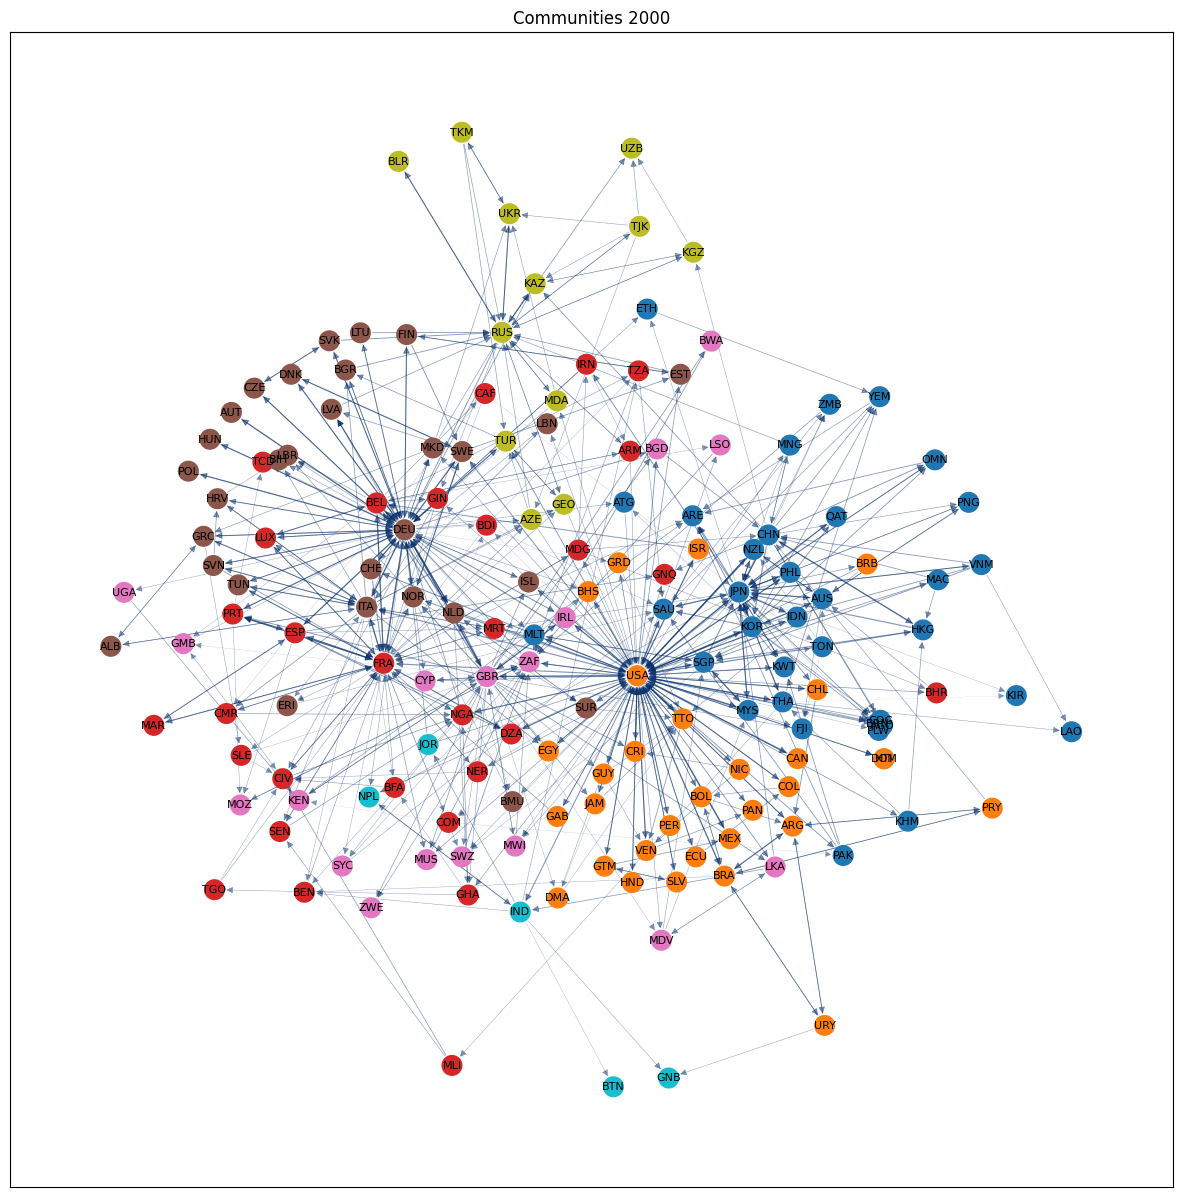

In [29]:
# draw the graph
pos = nx.kamada_kawai_layout(G2000bin)
# color the nodes according to their partition
cmap = cm.get_cmap('tab10', max(partition_greedy.values()) + 1)
plt.figure(figsize=(15,15))

nx.draw_networkx_nodes(G2000bin, pos, partition_greedy.keys(), node_size=200,
                       cmap=cmap, node_color=list(partition_greedy.values()))
nx.draw_networkx_edges(G2000bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)
nx.draw_networkx_labels(G2000bin, pos, font_size = 8)
plt.title('Communities 2000')
plt.savefig('Commmunity2000.png')


plt.show()

# Analysis on original graph

## Density

In [30]:
density = nx.density(G2000)
print('Density 2000: {}'.format(density))

Density 2000: 0.6341226708074534


## Degree

In [31]:
degree = list(dict(G2000.degree()).values())
print('Standard deviation: {}'.format(np.std(degree)))
print('Mean: {}'.format(np.mean(degree)))
print('Median: {}'.format(np.median(degree)))
print('Min: {}'.format(np.min(degree)))
print('Max: {}'.format(np.max(degree)))
print("Assortativity coefficient: " + str(nx.degree_assortativity_coefficient(G2000)))

Standard deviation: 72.40645926672457
Mean: 202.91925465838509
Median: 212.0
Min: 25
Max: 301
Assortativity coefficient: -0.23485627001825196


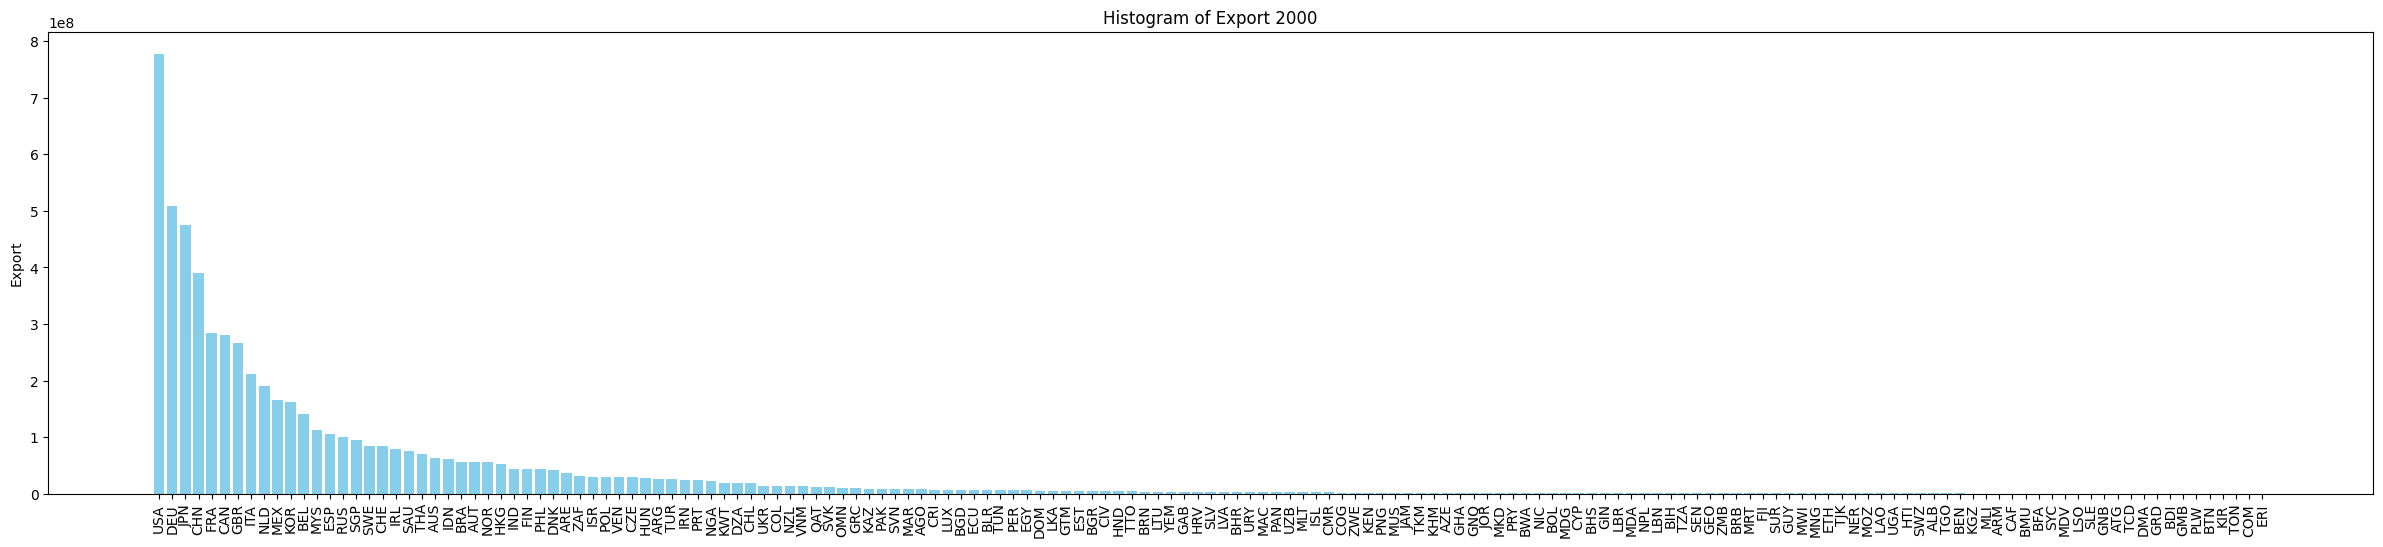

In [32]:
plot = 'Export'
plt.figure(figsize=(30, 6))
plt.bar(df_2000.sort_values(by=plot, ascending=False)['index'], df_2000.sort_values(by=plot, ascending=False)[plot], color='skyblue')
plt.ylabel(plot)
plt.title('Histogram of '+plot+' 2000')
plt.xticks(rotation=90)
plt.savefig(plot+"2000.png")
plt.show()


In [33]:
print(list(nx.isolates(G2000)))

[]


## Clustering

In [34]:
clusters = nx.average_clustering(G2000) #weight='price'
clusters

0.8205861901032114

In [35]:
local_cluster = nx.clustering(G2000, weight='price')
sorted(local_cluster.items(), key=lambda item: item[1], reverse= True)


[('USA', 0.0025397981005348515),
 ('DEU', 0.0018988913299849849),
 ('JPN', 0.0015187316267733103),
 ('GBR', 0.001420800071602929),
 ('FRA', 0.001326846233852207),
 ('CHN', 0.001181047737787676),
 ('ITA', 0.0011319304706863132),
 ('NLD', 0.0009350246966910111),
 ('BEL', 0.0008616893884106753),
 ('KOR', 0.0008134061512829864),
 ('ESP', 0.000751610036437428),
 ('CAN', 0.0007250392301898605),
 ('SGP', 0.0005998702232491032),
 ('HKG', 0.0005795952370694814),
 ('SWE', 0.0005715213546705808),
 ('CHE', 0.0005646880097699432),
 ('MYS', 0.0005531854230123261),
 ('MEX', 0.0005234315025352309),
 ('SAU', 0.0004976254263750466),
 ('RUS', 0.00048539875247162077),
 ('BRA', 0.0004693706197951396),
 ('AUS', 0.00046449795245565815),
 ('THA', 0.00045535516873538353),
 ('IRL', 0.00042667730196617053),
 ('AUT', 0.0004053262413289151),
 ('IND', 0.00039664650477405254),
 ('ISR', 0.0003963149904921274),
 ('DNK', 0.00037495684456160226),
 ('TUR', 0.0003737607857299243),
 ('IDN', 0.0003712711138304661),
 ('POL',

## Centrality

In [36]:
import statistics
deg_centr = nx.degree_centrality(G2000)
sort_orders = sorted(deg_centr.items(), key=lambda x: x[1], reverse=True)
avg_degree_centrality = sum(deg_centr.values()) / len(deg_centr)
print('average of degree centrality: {}'.format(avg_degree_centrality))

degree_centrality_values = list(deg_centr.values())
median_degree_centrality = statistics.median(degree_centrality_values)
print('median of degree centrality: {}'.format(median_degree_centrality))
print('min of degree centrality: {}'.format(sort_orders[-1]))
print('max of degree centrality: {}'.format(sort_orders[0]))

print("10 most important nodes for Degree Centrality:")
for i in range(10):
  print(sort_orders[i])

average of degree centrality: 1.2682453416149062
median of degree centrality: 1.3250000000000002
min of degree centrality: ('PLW', 0.15625)
max of degree centrality: ('DEU', 1.88125)
10 most important nodes for Degree Centrality:
('DEU', 1.88125)
('GBR', 1.88125)
('USA', 1.88125)
('FRA', 1.875)
('AUT', 1.8687500000000001)
('ITA', 1.8625)
('JPN', 1.8625)
('NLD', 1.8625)
('CHE', 1.8562500000000002)
('ESP', 1.8562500000000002)


## Betweeness

In [37]:
betweenesCentrality = nx.betweenness_centrality(G2000, weight='price')
sort_orders = sorted(betweenesCentrality.items(), key=lambda x: x[1], reverse=True)

avg_degree_betweenesCentrality = sum(betweenesCentrality.values()) / len(betweenesCentrality)
print('average of bewteenness centrality: {}'.format(avg_degree_betweenesCentrality))
print("10 most important nodes for Betweennes Centrality:")
print('max of betweenes centrality: {}'.format(sort_orders[0]))
for i in range(10):
  print(sort_orders[i])

average of bewteenness centrality: 0.023703806789327705
10 most important nodes for Betweennes Centrality:
max of betweenes centrality: ('COM', 0.23600628930817608)
('COM', 0.23600628930817608)
('BFA', 0.22710298742138363)
('BRB', 0.21696147798742138)
('TZA', 0.16436713836477987)
('BGR', 0.1613993710691824)
('ZMB', 0.14066430817610062)
('NER', 0.1313875786163522)
('LBN', 0.11898584905660377)
('SLE', 0.11375786163522011)
('ARG', 0.09992138364779873)


## Eigenvector

In [38]:
eigen = nx.eigenvector_centrality(G2000, weight='price')
sort_orders = sorted(eigen.items(), key=lambda x: x[1], reverse=True)

avg_degree_eignCentrality = sum(eigen.values()) / len(eigen)
print('average of eignvector centrality: {}'.format(avg_degree_eignCentrality))
print('max of eigenvector centrality: {}'.format(sort_orders[0]))
print("10 most important nodes for Eigenvector Centrality:")
for i in range(10):
  print(sort_orders[i])

average of eignvector centrality: 0.026315826801477715
max of eigenvector centrality: ('USA', 0.543246554677488)
10 most important nodes for Eigenvector Centrality:
('USA', 0.543246554677488)
('CAN', 0.4258182722957077)
('JPN', 0.3982364604591372)
('CHN', 0.3103026791014527)
('MEX', 0.259769482011909)
('DEU', 0.23844436852839282)
('GBR', 0.16098839254833866)
('FRA', 0.14838939459678965)
('KOR', 0.14154869527910624)
('ITA', 0.11408808076268728)


## Pagerank

In [39]:
pagerank = nx.pagerank(G2000, alpha=0.85, weight='price')
sort_orders = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)


avg_degree_pagerank = sum(pagerank.values()) / len(pagerank)
print('average of pagerank : {}'.format(avg_degree_pagerank))
print('max of pagerank: {}'.format(sort_orders[0]))
print("10 most important nodes for Page Rank:")
for i in range(10):
  print(sort_orders[i])

average of pagerank : 0.006211180124223602
max of pagerank: ('USA', 0.11107632303758054)
10 most important nodes for Page Rank:
('USA', 0.11107632303758054)
('DEU', 0.07044771593107085)
('JPN', 0.06297584470521664)
('CHN', 0.043912110265067444)
('FRA', 0.04268617740556599)
('GBR', 0.039401292108348196)
('ITA', 0.030746322026588953)
('CAN', 0.02777617888863755)
('NLD', 0.02625417999735005)
('KOR', 0.023606915351493764)


## Closeness

In [40]:
closeness = nx.closeness_centrality(G2000)
sort_orders = sorted(closeness.items(), key=lambda x: x[1], reverse=True)

avg_degree_closeness = sum(closeness.values()) / len(closeness)
print('average of closeness : {}'.format(avg_degree_closeness))

print("10 most important nodes for closeness_centrality:")
for i in range(10):
  print(sort_orders[i])

average of closeness : 0.7058456157859913
10 most important nodes for closeness_centrality:
('CHE', 0.88125)
('DEU', 0.88125)
('DNK', 0.88125)
('GBR', 0.88125)
('USA', 0.88125)
('BEL', 0.875044014084507)
('CHN', 0.875044014084507)
('ESP', 0.875044014084507)
('FRA', 0.875044014084507)
('ITA', 0.875044014084507)


## Communities

In [41]:
import networkx.algorithms.community as nx_comm
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

list_community_sets_greedy = list(nx_comm.greedy_modularity_communities(G2000,weight='price'))
print(list_community_sets_greedy[0:20])

[frozenset({'GNQ', 'MRT', 'GIN', 'FRA', 'LUX', 'TCD', 'RUS', 'NLD', 'ESP', 'DNK', 'BGR', 'LBR', 'GEO', 'TUR', 'CHE', 'CMR', 'SVN', 'BLR', 'BFA', 'SEN', 'NOR', 'MLI', 'DZA', 'CZE', 'AZE', 'BEL', 'CAF', 'PRT', 'SVK', 'TJK', 'EGY', 'TUN', 'UZB', 'ARM', 'GHA', 'FIN', 'LBN', 'MAR', 'GRC', 'HRV', 'POL', 'IRL', 'ALB', 'EST', 'GBR', 'BIH', 'MKD', 'BMU', 'SWE', 'LVA', 'GMB', 'TKM', 'BEN', 'AUT', 'LTU', 'SLE', 'KGZ', 'CIV', 'UKR', 'ISL', 'MDA', 'KAZ', 'CYP', 'MLT', 'ITA', 'TGO', 'HUN', 'DEU'}), frozenset({'AUS', 'NPL', 'MAC', 'QAT', 'ZMB', 'HKG', 'MYS', 'KEN', 'SWZ', 'BGD', 'KIR', 'BDI', 'MOZ', 'ZWE', 'BRN', 'PLW', 'VNM', 'THA', 'LSO', 'MWI', 'BWA', 'COM', 'UGA', 'BHR', 'PHL', 'KOR', 'SYC', 'JOR', 'KHM', 'SAU', 'BTN', 'ZAF', 'ETH', 'NZL', 'CHN', 'YEM', 'GNB', 'IDN', 'FJI', 'TZA', 'MDG', 'IRN', 'ARE', 'MNG', 'PNG', 'KWT', 'NER', 'TON', 'MDV', 'IND', 'ERI', 'COG', 'PAK', 'JPN', 'OMN', 'SGP', 'LAO', 'LKA', 'MUS'}), frozenset({'SLV', 'NGA', 'BRB', 'PER', 'MEX', 'ATG', 'SUR', 'NIC', 'HND', 'DOM', 'VE

In [42]:
partition_greedy = {}
for i, comm in enumerate(list_community_sets_greedy):
    print("Community:", i)
    print("Number of elems",len(comm))
    for n in comm:
        partition_greedy[n]=i

Community: 0
Number of elems 68
Community: 1
Number of elems 59
Community: 2
Number of elems 34


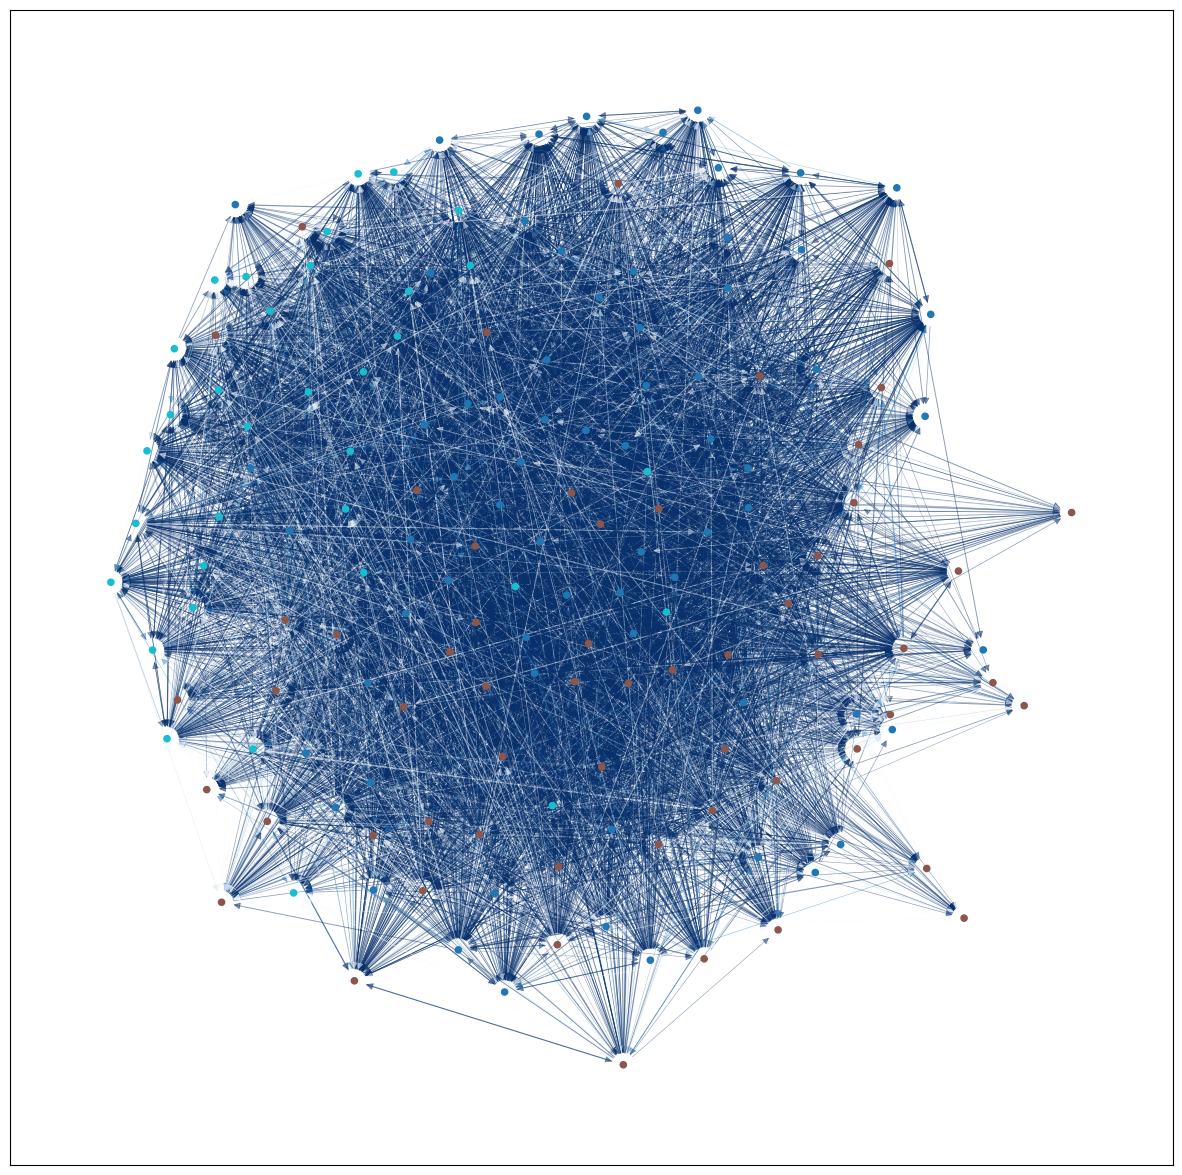

In [43]:
edges = G2000.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]
# draw the graph
pos = nx.kamada_kawai_layout(G2000)
# color the nodes according to their partition
cmap = cm.get_cmap('tab10', max(partition_greedy.values()) + 1)
plt.figure(figsize=(15,15))

nx.draw_networkx_nodes(G2000, pos, partition_greedy.keys(), node_size=20,
                       cmap=cmap, node_color=list(partition_greedy.values()))
nx.draw_networkx_edges(G2000, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)


plt.show()

## Data correlations

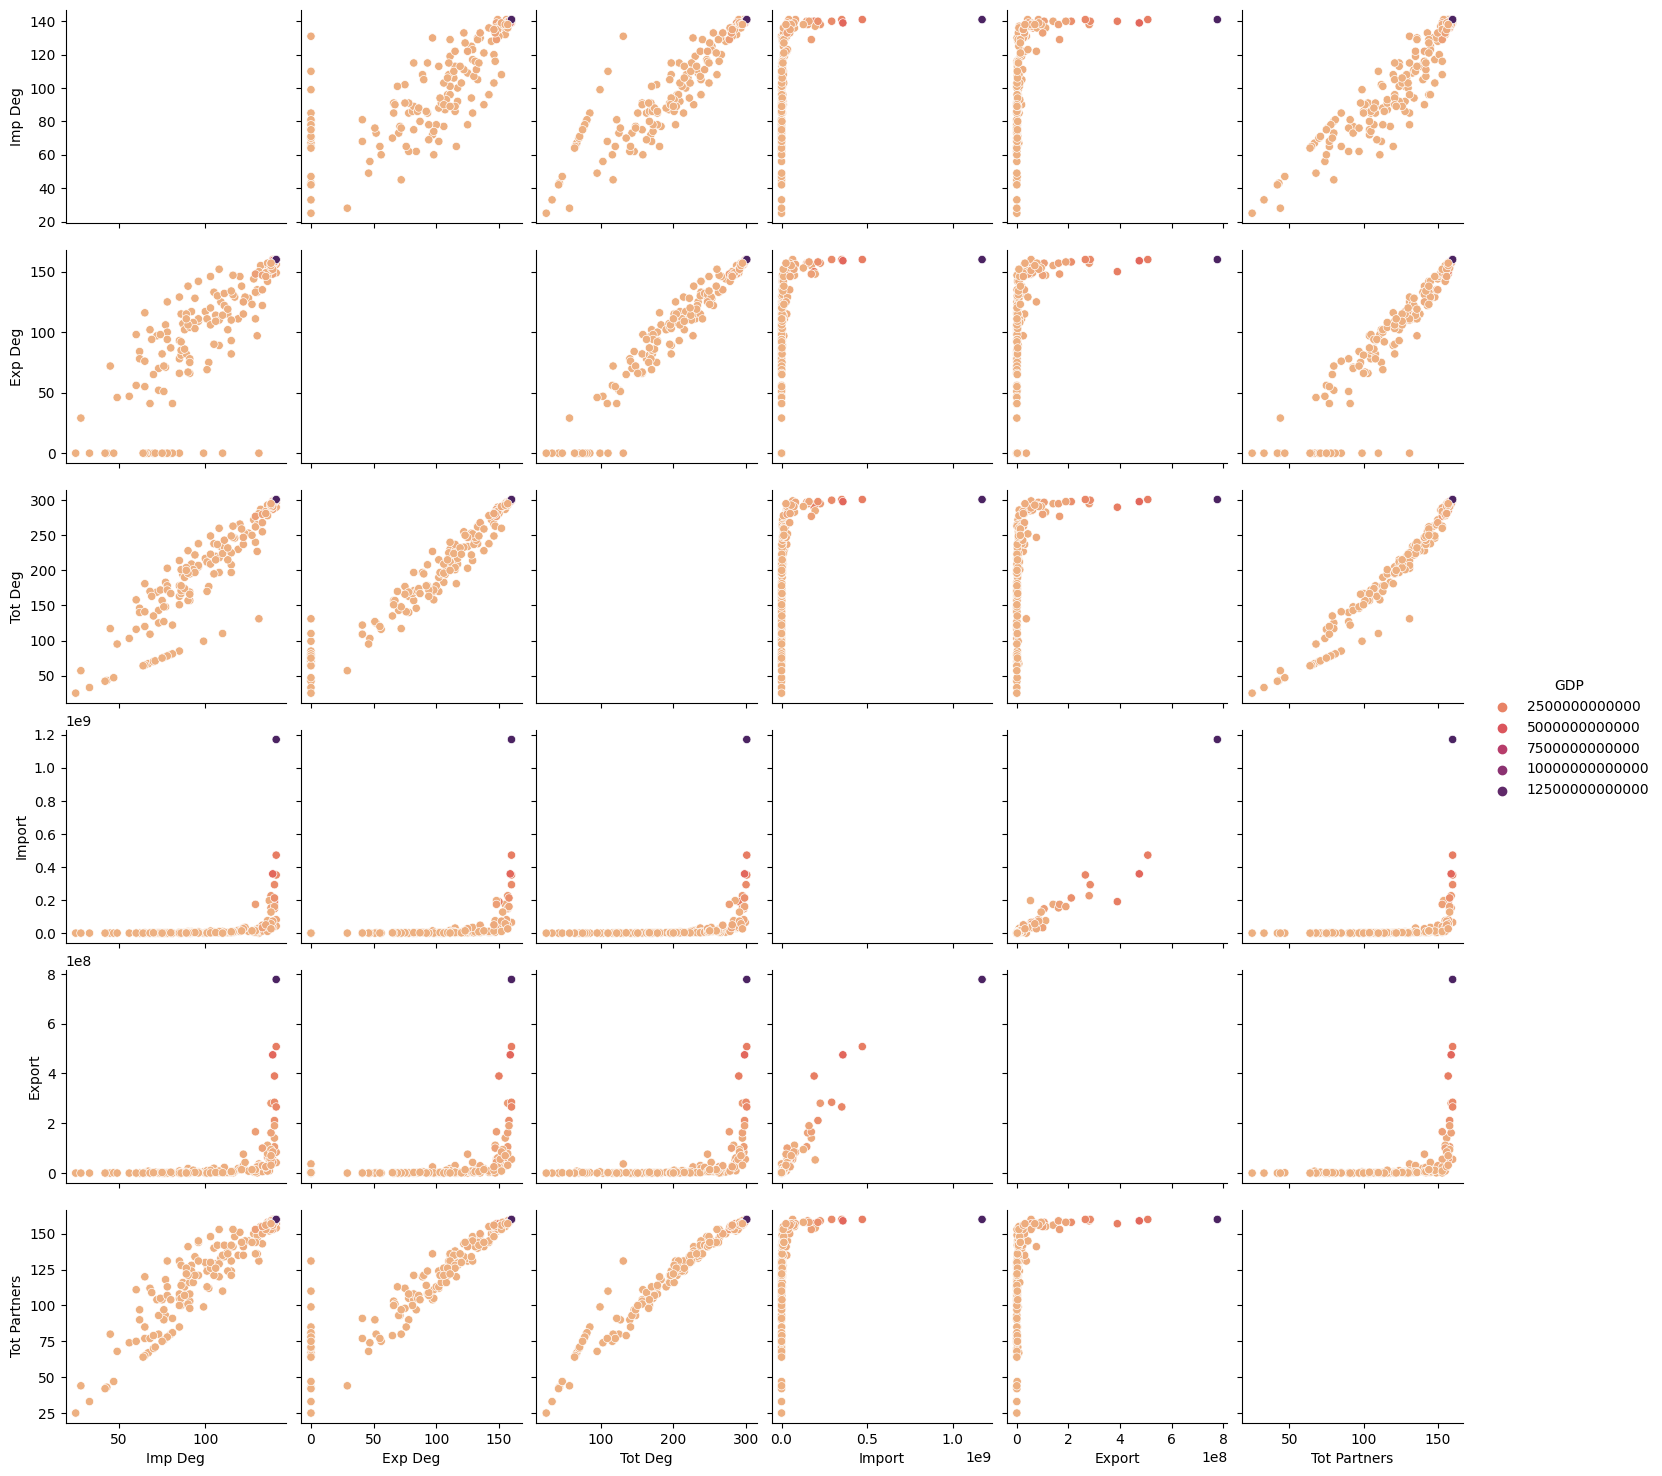

In [44]:
sns.pairplot(df_2000, hue = 'GDP'
             , diag_kind='auto',
             palette='flare'
            )